In [1]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np
import keras
!pip install scikeras
import scikeras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier




[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



### Import CSV and transform 

In [2]:

df = pd.read_csv("F:\Git\Food-price-forecast\ModelsAndDatasets\Datasets\price_temp_grain_starch.csv")
df = df.drop(columns=["Unnamed: 0"])   #Lösche unnötige Spalte
df.index = pd.to_datetime(df['Date'], format = '%Y-%m') #Datum als Index
df = df[df.Date <= "2021-12-01"]  #Alles vor 2022
df = df.drop(columns=["Date"], axis = 1)
df

,Food_Price,Air_Temperature,grain_starch_output_price
Date,,,
1996-01-01,74.9,-2.82,87.3
1996-02-01,75.5,-2.18,87.4
1996-03-01,76.1,1.00,87.7
1996-04-01,76.4,8.40,87.8
1996-05-01,76.2,11.15,88.8
...,...,...,...
2021-08-01,114.2,16.40,107.2
2021-09-01,114.2,15.16,108.2
2021-10-01,114.2,9.63,112.8


In [3]:
ss = StandardScaler()
df = pd.DataFrame(ss.fit_transform(df),columns = df.columns)
df

,Food_Price,Air_Temperature,grain_starch_output_price
0,-1.255570,-1.876104,-0.671747
1,-1.205758,-1.777546,-0.662489
2,-1.155946,-1.287835,-0.634715
3,-1.131040,-0.148257,-0.625457
4,-1.147644,0.275235,-0.532876
...,...,...,...
307,2.007114,1.083720,1.170617
308,2.007114,0.892763,1.263198
309,2.007114,0.041160,1.689072
310,2.056926,-0.687246,1.911266


### Plot Food-Price

<Axes: >

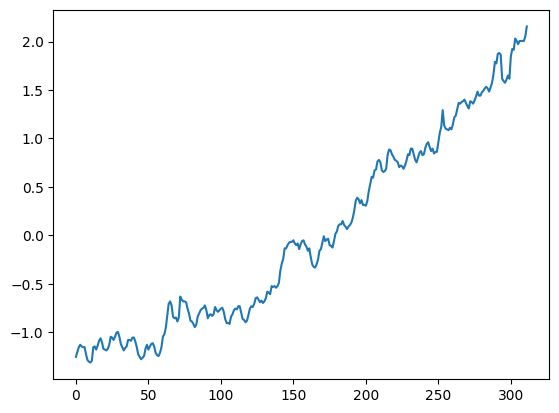

In [4]:
price = df["Food_Price"]
price.plot()


### Erstelle Sliding-Window Arrays

In [5]:
def df_to_X_y(df, window_size=5): #gebe DataFrame und Zeitraum der zu berücksichtigenden Perioden für Vorhersage an 
    df_as_np = df.to_numpy()
    X = [] # Vergangene Werte für Vorhersage
    y = [] # Labels für zu vorhersagende Periode

    for i in range(len(df_as_np)-window_size): #Iteration über numpy-Liste der Werte abzüglich window size
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)          #Gebe Zeitreihe für X und y zurück

#### Überprüfe Format 

In [6]:
window = 9
X, y = df_to_X_y(df, window)
X.shape, y.shape

((303, 9, 3), (303,))

#### Erstelle Test-Train Split

In [7]:
X_train, y_train = X[:250], y[:250]
X_val, y_val = X[250:275], y[250:275]
X_test, y_test = X[275:], y[275:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape  #Überprüfufe Form der Splits

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

## Model-Definition & Training

### Erstelle LSTM-Model with Tensorflow

In [35]:
np.random.seed = 42

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adagrad

#definiere Model als Function für GridSearch

def define_model(drop=0.1,optimizer ="Adam"):
    model7 = Sequential()
    model7.add(LSTM(64, activation='relu', input_shape=(window, 3), return_sequences=True))
    model7.add(LSTM(32, activation='relu', return_sequences=False))
    model7.add(Dropout(drop))
    model7.add(Dense(1))

    model7.compile(optimizer=optimizer, loss='mape', metrics=["mape"])
    
    return model7



### Grid-Search

In [12]:
from scikeras.wrappers import KerasRegressor
batch_size = 32
epochs = 300

model = KerasRegressor(
                       build_fn=define_model,
                       epochs=epochs,
                       batch_size=batch_size,                     
                       verbose=1,
                       drop = 0.1,
                       )

optimizer = ['SGD', 'RMSprop', 'Adagrad']
drop = [0.1,0.05,0.01,0.005]

param_grid = dict(drop = drop,optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs = 8, cv= 5)

grid_result = grid.fit(X_train, y_train)



f:\Git\Food-price-forecast\venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/300
8/8 [==============================] - 2s 6ms/step - loss: 103.6117 - mape: 103.6117
Epoch 2/300
8/8 [==============================] - 0s 6ms/step - loss: 95.4881 - mape: 95.4881
Epoch 3/300
8/8 [==============================] - 0s 6ms/step - loss: 89.0144 - mape: 89.0144
Epoch 4/300
8/8 [==============================] - 0s 6ms/step - loss: 82.2708 - mape: 82.2708
Epoch 5/300
8/8 [==============================] - 0s 5ms/step - loss: 71.1255 - mape: 71.1255
Epoch 6/300
8/8 [==============================] - 0s 5ms/step - loss: 48.6468 - mape: 48.6468
Epoch 7/300
8/8 [==============================] - 0s 6ms/step - loss: 31.1142 - mape: 31.1142
Epoch 8/300
8/8 [==============================] - 0s 5ms/step - loss: 30.1910 - mape: 30.1910
Epoch 9/300
8/8 [==============================] - 0s 5ms/step - loss: 25.9389 - mape: 25.9389
Epoch 10/300
8/8 [==============================] - 0s 5ms/step - loss: 25.6654 - mape: 25.6654
Epoch 11/300
8/8 [=============================

In [29]:
print("Best: %f using %s" %(grid_result.best_score_,grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean,stdev,param in zip(means,stds,params):
    print("Mean = %f (std=%f) with: %r" % (mean,stdev,param))

Best: -0.928071 using {'drop': 0.1, 'optimizer': 'RMSprop'}
Mean = -1.216274 (std=2.093926) with: {'drop': 0.1, 'optimizer': 'SGD'}
Mean = -0.928071 (std=2.086987) with: {'drop': 0.1, 'optimizer': 'RMSprop'}
Mean = -1.021720 (std=2.221306) with: {'drop': 0.1, 'optimizer': 'Adagrad'}
Mean = -1.237527 (std=2.171529) with: {'drop': 0.05, 'optimizer': 'SGD'}
Mean = -2.006493 (std=2.118454) with: {'drop': 0.05, 'optimizer': 'RMSprop'}
Mean = -1.411304 (std=2.198137) with: {'drop': 0.05, 'optimizer': 'Adagrad'}
Mean = -1.810449 (std=2.132498) with: {'drop': 0.01, 'optimizer': 'SGD'}
Mean = -2.197011 (std=2.293604) with: {'drop': 0.01, 'optimizer': 'RMSprop'}
Mean = -1.770883 (std=1.989682) with: {'drop': 0.01, 'optimizer': 'Adagrad'}
Mean = -1.872563 (std=2.249908) with: {'drop': 0.005, 'optimizer': 'SGD'}
Mean = -2.044613 (std=2.095527) with: {'drop': 0.005, 'optimizer': 'RMSprop'}
Mean = -1.274365 (std=2.058076) with: {'drop': 0.005, 'optimizer': 'Adagrad'}


### Anweisung, dass nur bestes Modell nach Training gespeichert werden soll

In [42]:
best_model = define_model(drop=0.1, optimizer="RMSprop")
cp7 = ModelCheckpoint("model7/", save_best_only=True)


### Model Training mit Training und Validation Dataset

In [43]:
best_model.fit(X_train, y_train, epochs=600, validation_data = (X_val,y_val), batch_size=32, verbose=0, callbacks=[cp7]).history

INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


INFO:tensorflow:Assets written to: model7\assets


{'loss': [95.28092193603516,
  72.61849212646484,
  55.97763442993164,
  42.44581604003906,
  36.44816970825195,
  32.27925109863281,
  32.356807708740234,
  27.264511108398438,
  28.277936935424805,
  25.17904281616211,
  26.521800994873047,
  25.627458572387695,
  23.556365966796875,
  22.116558074951172,
  22.800575256347656,
  20.372365951538086,
  23.45269203186035,
  24.61357307434082,
  22.526500701904297,
  21.641557693481445,
  21.928199768066406,
  19.20671272277832,
  21.10706329345703,
  19.417613983154297,
  21.01038360595703,
  22.595090866088867,
  19.542757034301758,
  20.368776321411133,
  18.407997131347656,
  18.61007308959961,
  19.123733520507812,
  21.457494735717773,
  17.918367385864258,
  20.967195510864258,
  20.920825958251953,
  18.81757354736328,
  18.026721954345703,
  18.42323112487793,
  18.49536895751953,
  20.77482032775879,
  18.514978408813477,
  18.337787628173828,
  19.235429763793945,
  17.65964698791504,
  17.684240341186523,
  17.07065773010254,

### Lade beste Modelle aus Training

In [44]:
from tensorflow.keras.models import load_model
model7 = load_model('model7/')


## Vorhersage & Performance



Training-MAPE 6.288389682769775
Validation-MAPE 5.259130477905273
Test-MAPE 5.940537929534912


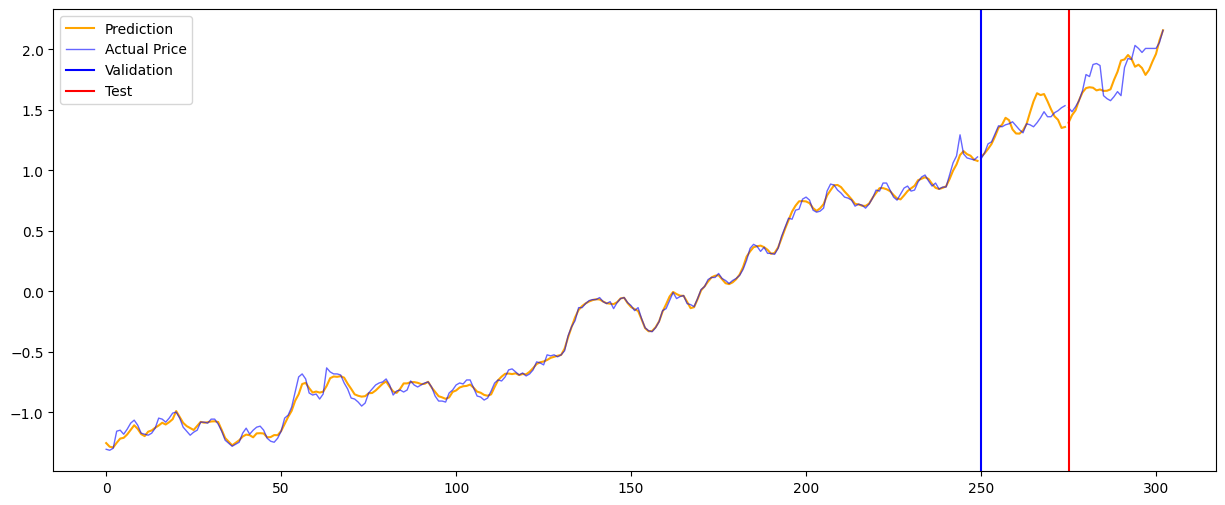

In [58]:
plt.figure(figsize=(15,6))

plt.plot(train_results['Train Predictions'],label='Prediction', color = "orange")
plt.plot(train_results['Actuals'],label='Actual Price', color = "b",alpha=0.6, linewidth = 1.0)
plt.plot(np.arange(len(val_results))+len(train_results),val_results['Validation Predictions'],color = 'orange')
plt.plot(np.arange(len(val_results))+len(train_results),val_results['Actuals'], color = "b",alpha=0.6, linewidth = 1.0)
plt.plot(np.arange(len(test_results))+len(train_results)+len(val_results),test_results['Test Predictions'], color = "orange")
plt.plot(np.arange(len(test_results))+len(train_results)+len(val_results),test_results['Actuals'],color = "b",alpha=0.6, linewidth = 1.0)
plt.axvline(x = 250, color = 'b', label = 'Validation')
plt.axvline(x = 275, color = 'r', label = 'Test')
plt.legend()
plt.legend()

print(f"Training-MAPE {tf.keras.metrics.mean_absolute_percentage_error(train_results['Train Predictions'],train_results['Actuals'])}")
print(f"Validation-MAPE {tf.keras.metrics.mean_absolute_percentage_error(val_results['Validation Predictions'],val_results['Actuals'])}")
print(f"Test-MAPE {tf.keras.metrics.mean_absolute_percentage_error(test_results['Test Predictions'],test_results['Actuals'])}")


### Training Data-Set isolierte Ansicht

In [45]:
train_predictions = model7.predict(X_train).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
train_results = pd.DataFrame(data={'Train Predictions':train_predictions,'Actuals': y_train}) 
train_results

tf.keras.metrics.mean_absolute_percentage_error(train_results['Train Predictions'],train_results['Actuals'])  #Mean Absolute percentage Error

8/8 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=6.2883897>

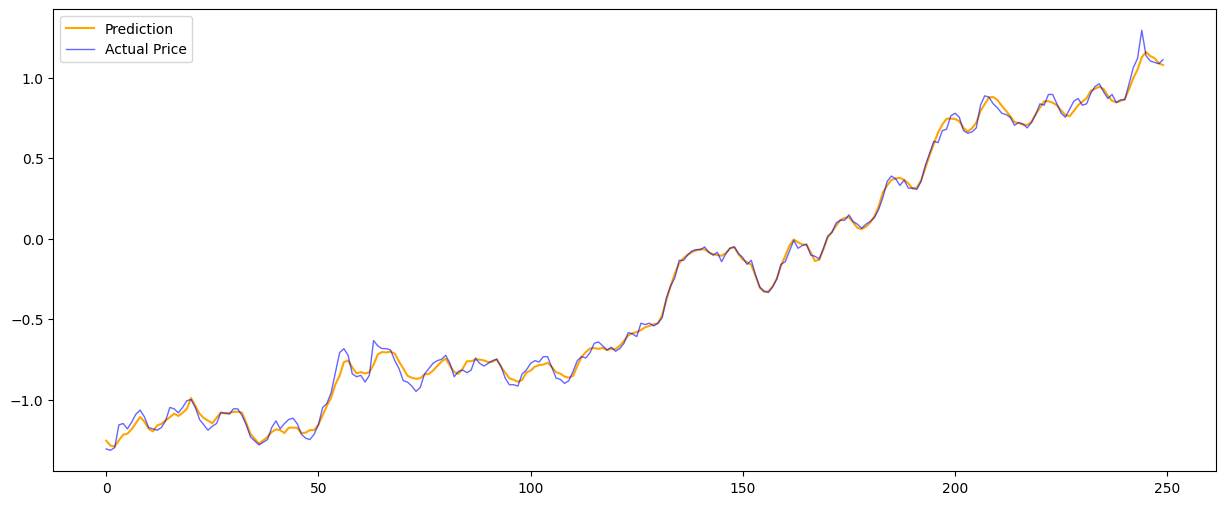

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(train_results['Train Predictions'],label='Prediction', color ="orange")
plt.plot(train_results['Actuals'],label='Actual Price',alpha=0.6, linewidth = 1.0, color ="b")
plt.legend()



### Validation Data-Set islolierte Ansicht

In [47]:
val_predictions = model7.predict(X_val).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
val_results = pd.DataFrame(data={'Validation Predictions':val_predictions,'Actuals': y_val}) 
val_results

tf.keras.metrics.mean_absolute_percentage_error(val_results['Validation Predictions'],val_results['Actuals'])

1/1 [==============================] - 0s 19ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=5.2591305>

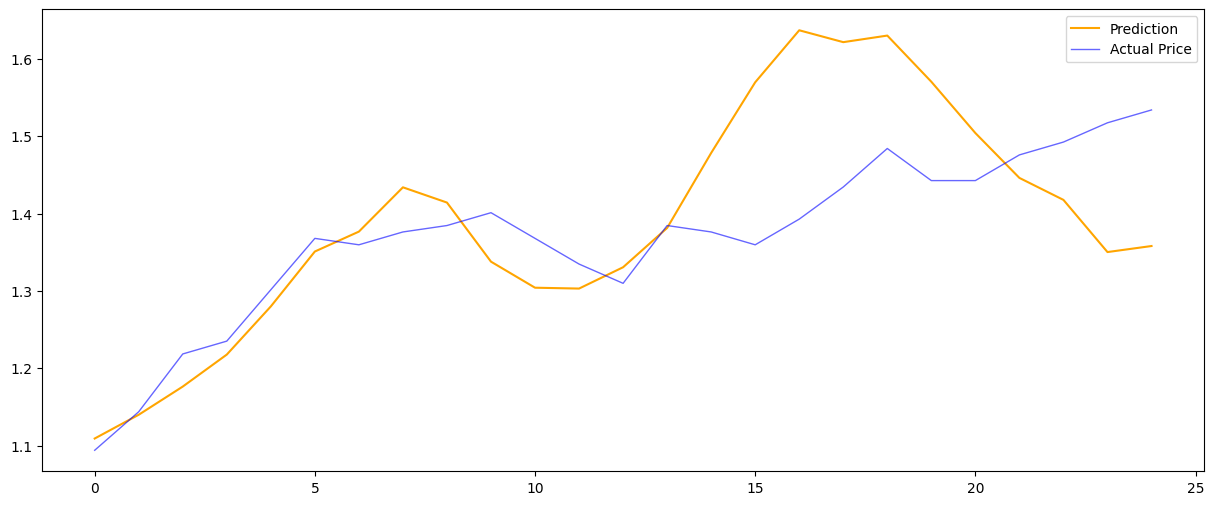

In [60]:
plt.figure(figsize=(15,6))
plt.plot(val_results['Validation Predictions'],label='Prediction', color="orange")
plt.plot(val_results['Actuals'],label='Actual Price',alpha=0.6, linewidth = 1.0, color ="b")
plt.legend()


### Test Data-Set isolierte Ansicht

In [49]:
test_predictions = model7.predict(X_test).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
test_results = pd.DataFrame(data={'Test Predictions':test_predictions,'Actuals': y_test}) 
test_results

tf.keras.metrics.mean_absolute_percentage_error(test_results['Test Predictions'],test_results['Actuals'])

1/1 [==============================] - 0s 20ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=5.940538>

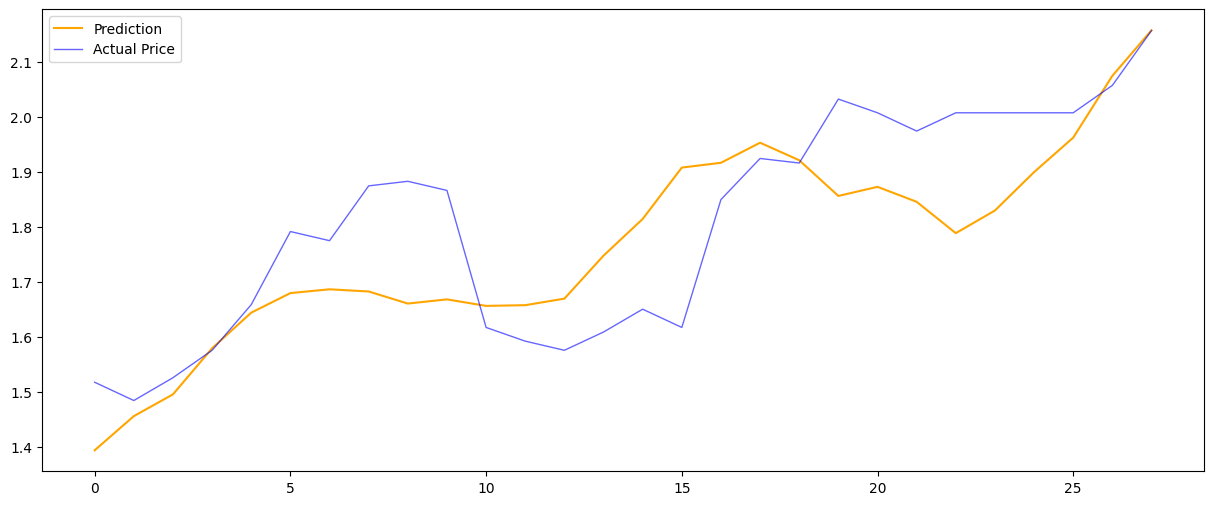

In [61]:
plt.figure(figsize=(15,6))
plt.plot(test_results['Test Predictions'],label='Prediction',color = "orange")
plt.plot(test_results['Actuals'],label='Actual Price',alpha=0.6, linewidth = 1.0, color ="b")
plt.legend()
